# More Examples 

Any user of Webbpsf is invited to submit snippets of example code for sharing here.

The following examples all assume you have started with

In [2]:
import webbpsf
import numpy as np
# if running in a Jupyter notebook also do:
%pylab inline  

Populating the interactive namespace from numpy and matplotlib


Examples are organized by topic:

* Typical Usage Cases
* Spectroscopic PSFs
* Coronagraphy and complications
* Additional examples of SI modes

## Notebook Interface

WebbPSF includes a Jupyter notebook widget interface which facilitates simple calculations.

In [28]:
webbpsf.show_notebook_interface('nircam')

## Typical Usage Cases

### Displaying a PSF as an image and as an encircled energy plot

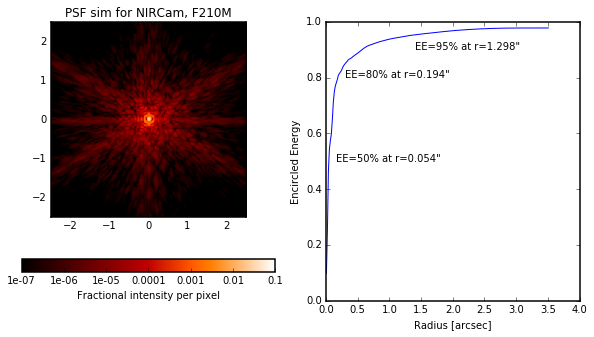

In [4]:
# create a NIRCam instance and calculate a PSF for F210M
nircam = webbpsf.NIRCam()
nircam.filter = 'F210M'
psf210 = nircam.calc_psf(oversample=2)

# display the PSF and plot the encircled energy
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
webbpsf.display_psf(psf210, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
webbpsf.display_ee(psf210, ax=axis2)

psf210.writeto('nircam_F210M.fits', clobber=True)
plt.savefig('plot_nircam_f210m.pdf')

### Iterating over multiple OPDs and filters

Perhaps you want to calculate PSFs for all filters of a given instrument, using all available simulated OPDs:

In [4]:
def niriss_psfs():
    niriss = webbpsf.NIRISS()
    opdname = niriss.pupilopd

    for i in range(10):
        niriss.pupilopd = (opdname,i)
        for filtname in niriss.filter_list:
            niriss.filter=filtname
            fov=18
            outname = "PSF_NIRISS_%scen_wfe%d.fits" % (filtname, i)
            psf = niriss.calc_psf(outname, niriss, nlambda=1,
                                           oversample=4, fov_arcsec=fov, rebin=True, display=True)


### Create monochromatic PSFs across an instrument’s entire wavelength range

Monochromatic PSFs with steps of 0.1 micron from 5-28.3 micron.

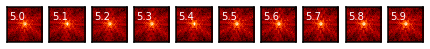

In [13]:
m = webbpsf.MIRI()
m.pupilopd = 'OPD_RevV_miri_421.fits'       # select an OPD
                                            # path is $WEBBPSF_DATA/MIRI/OPD by default
                                            # or you can specify a full path name.
m.options['parity'] = 'odd'                 # please make an output PSF with its center
                                            # aligned to the center of a single pixel

waves = np.linspace(5.0, 28.3, 234)*1e-6    # iterate over wavelengths in meters
waves=waves[0:10]
plt.figure(figsize=(12,12))

for iw, wavelength in enumerate(waves):
    psffile = 'PSF_MIRI_mono_%.1fum_revV_opd1.fits' % (wavelength*1e6)
    psf = m.calc_psf(fov_arcsec=10, oversample=2, rebin=True, monochromatic=wavelength, display=False,
               outfile=psffile)
    ax = plt.subplot(16,16,iw+1)
    webbpsf.display_psf(psffile, ext='DET_SAMP', colorbar=False, imagecrop=8)
    ax.set_title('')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(-3.5, 1, '{0:.1f}'.format(wavelength*1e6), color='white')


## Spectroscopic PSFs, Slit and Slitless

Note that WebbPSF does not compute dispersed spectroscopic PSFs, but you can compute monochromatic PSFs and combine them yourself with an appropriate dispersion model.

###  NIRSpec fixed slits

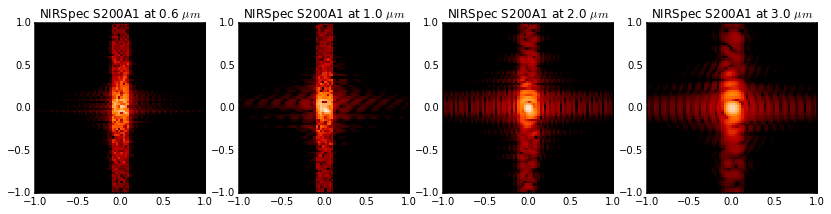

In [5]:
plt.figure(figsize=(14, 8))
nspec = webbpsf.NIRSpec()
nspec.image_mask = 'S200A1' # 0.2 arcsec slit

psfs = {}
for wave in [0.6e-6, 1e-6, 2e-6, 3e-6]:
    psfs[wave] = nspec.calcPSF(monochromatic=wave, oversample=4)

for i, wave in enumerate([0.6e-6, 1e-6, 2e-6, 3e-6]):
    plt.subplot(1, 4, i+1)
    webbpsf.display_psf(psfs[wave], colorbar=False, imagecrop=2,
                        title='NIRSpec S200A1 at {0:.1f} $\mu m$'.format(wave*1e6))
plt.savefig('example_nirspec_slitpsf.png')

### NIRSpec MSA

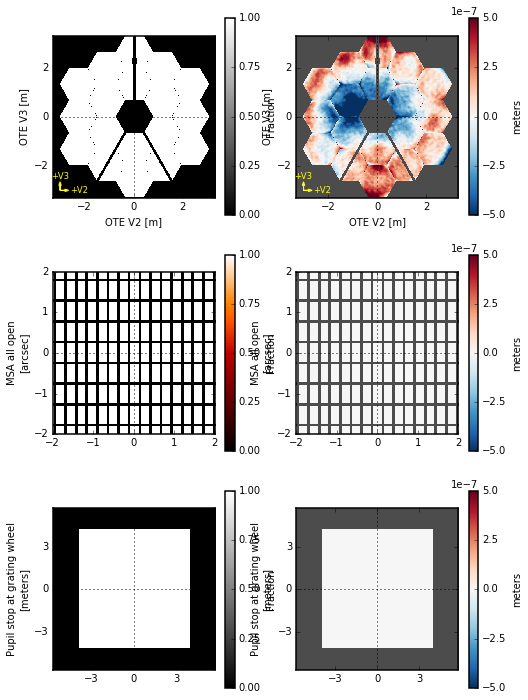

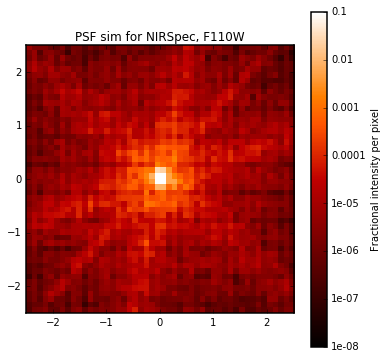

In [10]:
plt.figure(figsize=(8, 12))
ns = webbpsf.NIRSpec()
ns.image_mask='MSA all open'
ns.display()
plt.savefig('example_nirspec_msa_optics.png')
msapsf = ns.calc_psf(monochromatic=2e-6, oversample=8, rebin=True)
plt.figure(figsize=(6,6))
webbpsf.display_PSF(msapsf, ext='DET_SAMP')

### MIRI LRS

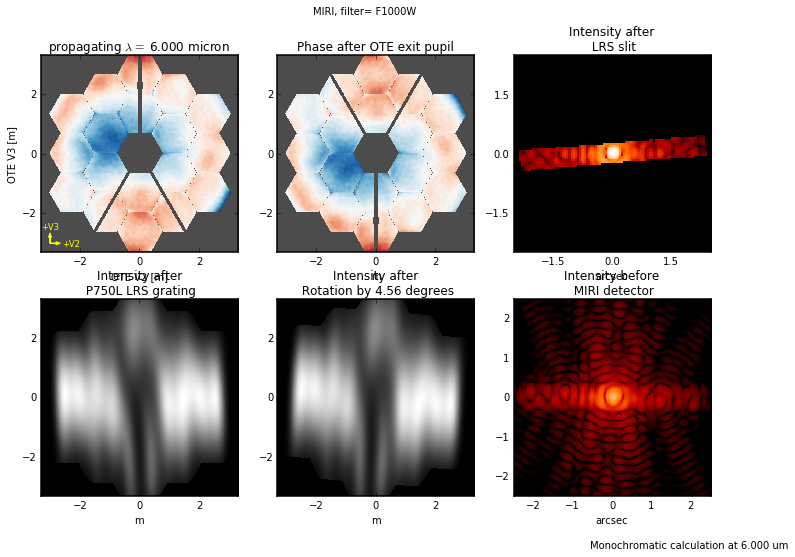

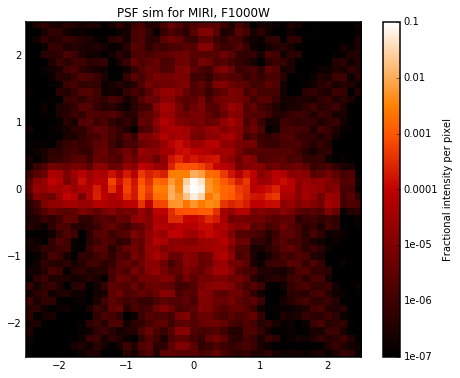

In [6]:
plt.figure(figsize=(12,8))
miri = webbpsf.MIRI()
miri.image_mask = 'LRS slit'
miri.pupil_mask = 'P750L LRS grating'
psf = miri.calc_psf(monochromatic=6.0e-6, display=True)
plt.figure(figsize=(8,6))
webbpsf.display_psf(psf,ext='DET_SAMP')

## Coronagraphy and Complications

### NIRCam coronagraphy with an offset source

In [ ]:
nc = webbpsf.NIRCam()
nc.filter='F430M'
nc.image_mask='MASK430R'
nc.pupil_mask='CIRCLYOT'
nc.options['source_offset_r'] = 0.20       # source is 200 mas from center of coronagraph
                                           # (note that this is MUCH larger than expected acq
                                           # offsets. This size displacement is just for show)
nc.options['source_offset_theta'] = 45     # at a position angle of 45 deg
nc.calc_psf('coronagraphic.fits', oversample=4, clobber=True)   # create highly oversampled output image


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_PSF('coronagraphic.fits', vmin=1e-10, vmax=1e-5, ext='OVERSAMP', title='NIRCam F430M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_PSF('coronagraphic.fits', vmin=1e-10, vmax=1e-5, ext='DET_SAMP', title='NIRCam F430M+MASK430R, detector oversampled', crosshairs=True)

plt.savefig('example_nircam_coron_resampling.png')

### Simulate NIRCam coronagraphic acquisition images

In [ ]:
def compute_psfs():
    nc = webbpsf.NIRCam()

    # acq filter, occulting mask, lyot, coords of acq ND square
    sets = [('F182M', 'MASKSWB', 'WEDGELYOT', -10,  7.5),
            ('F182M', 'MASK210R', 'CIRCLYOT', -7.5, 7.5),
            ('F335M', 'MASKLWB', 'WEDGELYOT',  7.5, 7.5),
            ('F335M', 'MASK335R', 'CIRCLYOT', -10,  7.5)]

    nlambda = 9
    oversample = 2

    calc_oversample=4

    fov_arcsec = 25

    for param in sets:
        nc.filter = param[0]
        nc.image_mask = param[1]
        nc.pupil_mask = param[2]
        source_offset_x = param[3]
        source_offset_y = param[4]


        source_offset_r = np.sqrt(source_offset_x**2+ source_offset_y**2)
        source_offset_theta = np.arctan2(source_offset_x, source_offset_y)*180/np.pi
        nc.options['source_offset_r'] = source_offset_r
        nc.options['source_offset_theta'] = source_offset_theta


        filename = "PSF_NIRCam_%s_%s_%s_offset.fits" % (param[0], param[1], param[2])
        result = nc.calc_psf(nlambda=nlambda,
            oversample=oversample, calc_oversample=calc_oversample,
            fov_arcsec=fov_arcsec, outfile=filename, display=False)

# Additional Examples of SI Modes

## NIRCam

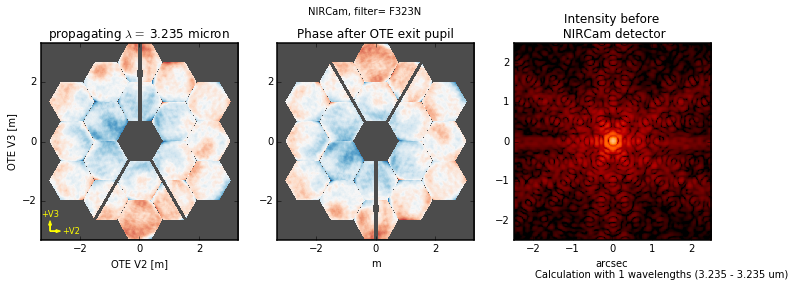

In [7]:
#Regular imaging
nc=webbpsf.NIRCam()
nc.filter='F323N'
plt.figure(figsize=(12,4))
p = nc.calc_psf(nlambda=1, display=True)

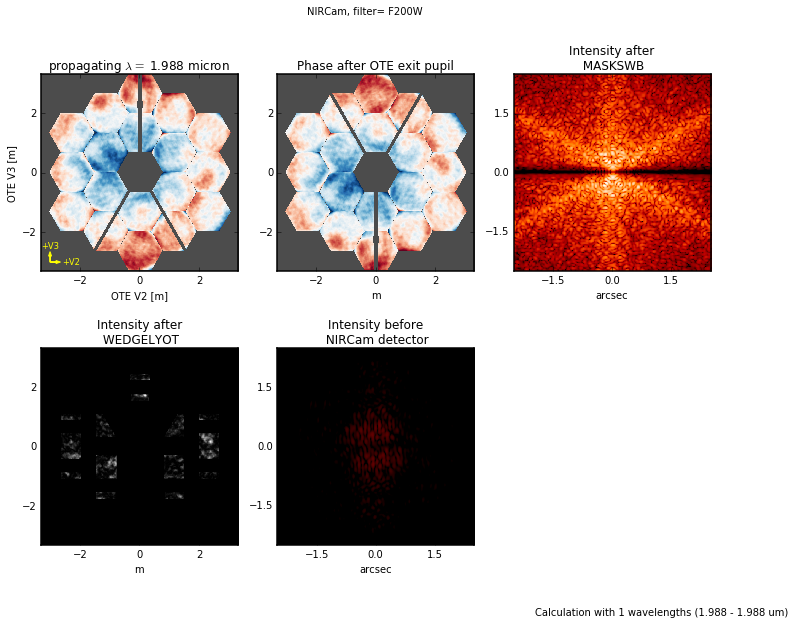

In [8]:
# coronagraphy
nc=webbpsf.NIRCam()
nc.image_mask='MASKSWB'
nc.pupil_mask='WEDGELYOT'
plt.figure(figsize=(12,9))
p = nc.calc_psf(nlambda=1, display=True)

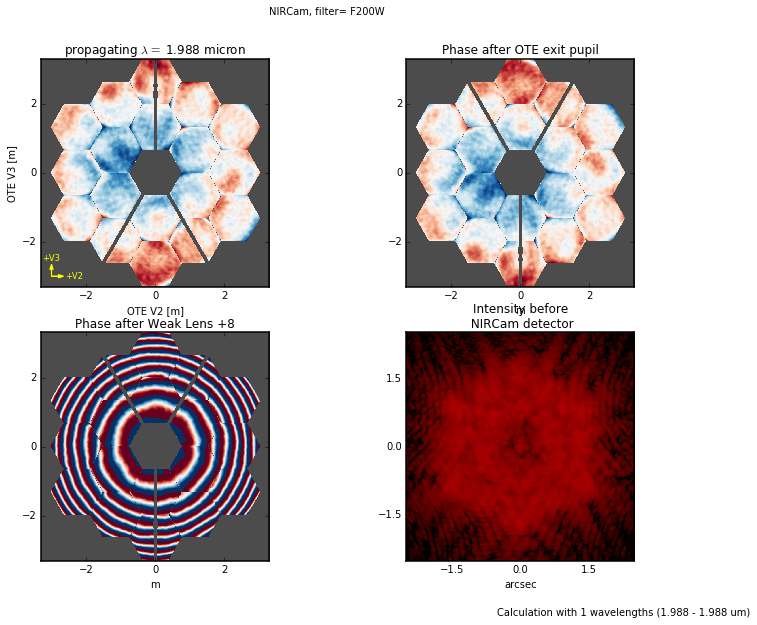

In [9]:
# wavefront sensing
nc=webbpsf.NIRCam()
nc.pupil_mask='WEAK LENS +8'
plt.figure(figsize=(12,9))
p = nc.calc_psf(nlambda=1, display=True)

## NIRISS

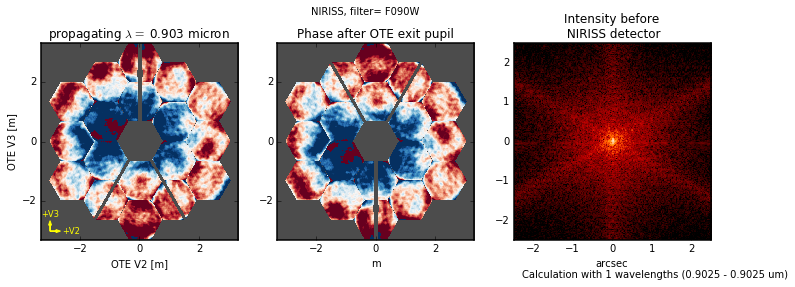

In [10]:
# NIRISS short wave PSF
# e.g. monochromatic PSF for slitless spectroscopy
ni=webbpsf.NIRISS()
ni.filter='F090W'
plt.figure(figsize=(12,4))
ni.calc_psf(nlambda=1, display=True)

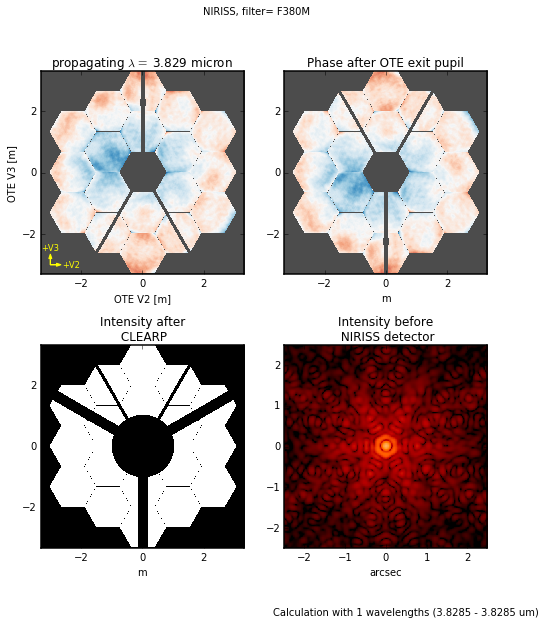

In [19]:
# NIRISS long wave imaging
# note selecting a long-wave filter auto-selects the CLEARP pupil mask
ni=webbpsf.NIRISS()
ni.filter='F380M'
plt.figure(figsize=(8,9))
ni.calc_psf(nlambda=1, display=True)

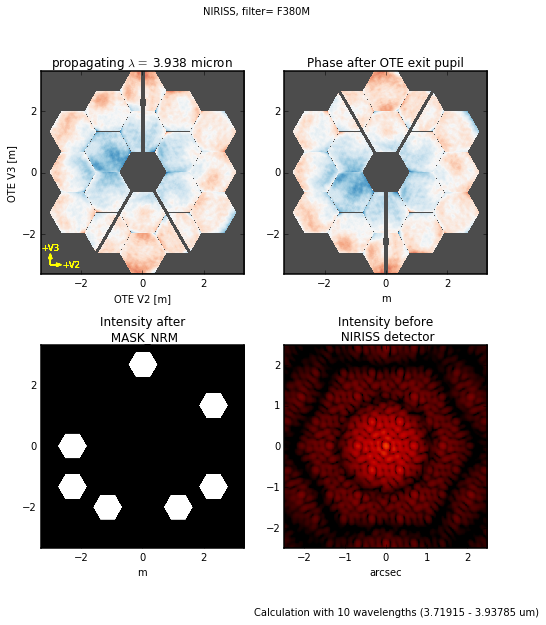

In [18]:
# NIRISS interferometry
ni=webbpsf.NIRISS()
ni.filter='F380M'
ni.pupil_mask='MASK_NRM'
plt.figure(figsize=(8,9))
ni.calc_psf(display=True)

## MIRI

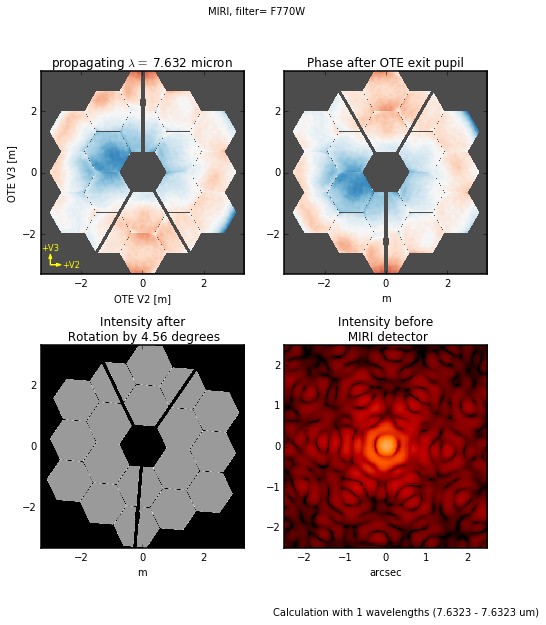

In [21]:
# regular MIRI imaging
miri = webbpsf.MIRI()
miri.filter='F770W'
plt.figure(figsize=(8,9))
miri.calc_psf(nlambda=1,display=True)

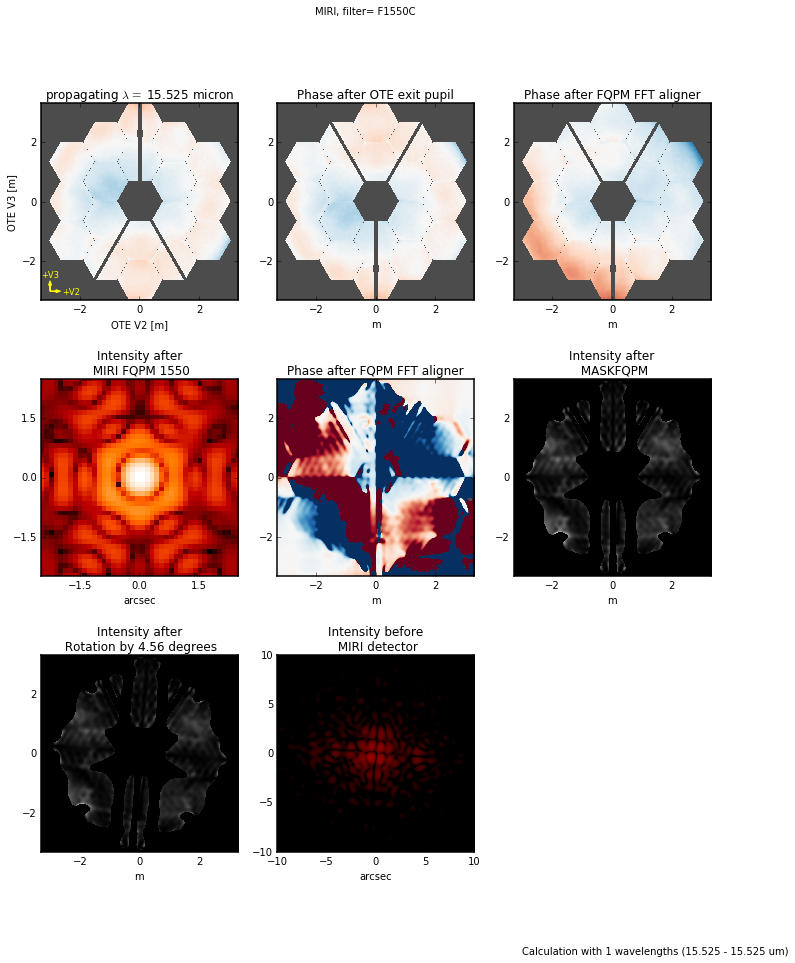

In [26]:
# MIRI FQPM Coronagraphy 
plt.figure(figsize=(12,12))
miri = webbpsf.MIRI()
miri.filter='F1550C'
miri.image_mask='FQPM1550'
miri.pupil_mask = 'MASKFQPM'
plt.figure(figsize=(12,14))
miri.calc_psf(nlambda=1, fov_arcsec=20, display=True)

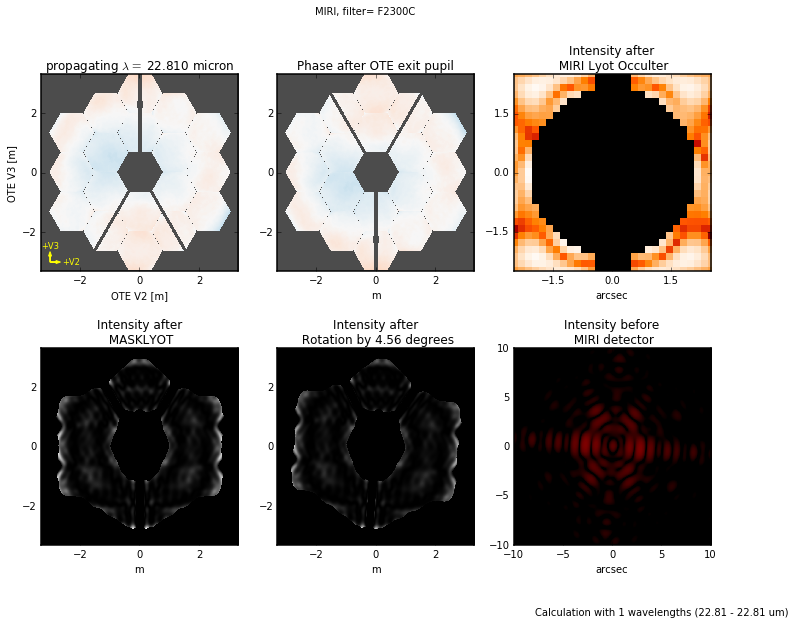

In [27]:
# MIRI Lyot Coronagraphy
miri = webbpsf.MIRI()
miri.filter='F2300C'
miri.image_mask='LYOT2300'
miri.pupil_mask = 'MASKLYOT'
plt.figure(figsize=(12,9))
miri.calc_psf(nlambda=1, fov_arcsec=20, display=True)

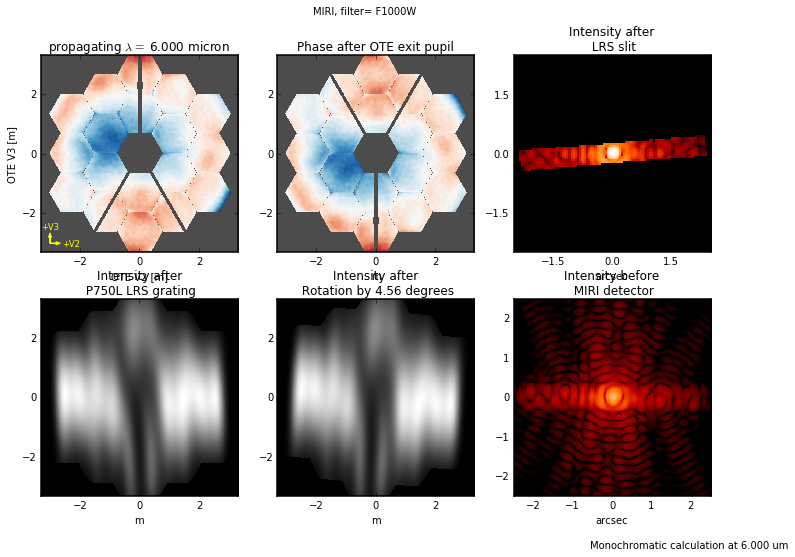

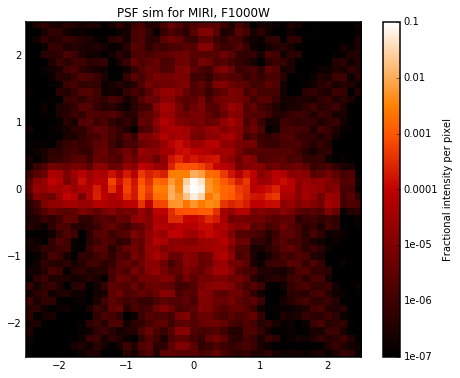

In [22]:
# MIRI LRS
plt.figure(figsize=(12,8))
miri = webbpsf.MIRI()
miri.image_mask = 'LRS slit'
miri.pupil_mask = 'P750L LRS grating'
psf = miri.calc_psf(monochromatic=6.0e-6, display=True)
plt.figure(figsize=(8,6))
webbpsf.display_psf(psf,ext='DET_SAMP')